## Imports and Initialization

In [1]:
#!pip install sympy==1.12 --force-reinstall

In [2]:
#import torchvision
#print(torchvision.__version__)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Prep

In [5]:
data_prefix = './datasets'

In [6]:
NUM_TRAIN = 49000
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar100_train = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar100_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = datasets.CIFAR100(data_prefix, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=64)

100%|██████████| 169M/169M [00:03<00:00, 46.4MB/s]


In [7]:
cifar100_train[0][0].shape

torch.Size([3, 32, 32])

## CNN Model

In [8]:
# RegDeepCNN(channels_list, pool_list)
# Flexible CNN with variable conv layers and optional 2x2 max pooling per layer.
# Args:
#  - channels_list (list of int): output channels per conv layer.
#  - pool_list (list of bool): whether to apply max pooling after each conv.
# Constraints:
#  - Input: 32x32 RGB images.
#  - Max pooling auto-disabled if it reduces spatial size below 4x4.
#  - channels_list and pool_list must be same length.
#  - Max 3 poolings allowed to keep spatial size ≥4x4.
# Example:
#  channels = [32,32,64,64]; pools = [False,True,False,True]
#  model = RegDeepCNN(channels, pools)
#  output = model(torch.randn(1,3,32,32))

In [9]:
class RegDeepCNN(nn.Module):
    def __init__(self, channels_list, pool_list):
        super(RegDeepCNN, self).__init__()

        assert len(channels_list) == len(pool_list), "channels_list and pool_list must be the same length"
        assert sum(pool_list) <= 3, "Too many poolings; spatial size < 4x4"

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.pool_bools = pool_list
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels = 3  # input RGB images

        for out_channels in channels_list:
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bns.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels

        # After conv layers, define a linear layer.
        # To calculate the input size for linear layer, you need to know the spatial size after conv+pool layers.
        # For example, assuming input 32x32 and each maxpool halves size:
        num_pools = sum(pool_list)
        final_spatial_size = 32 // (2 ** num_pools)
        final_channels = channels_list[-1]
        self.fc1 = nn.Linear(final_channels * final_spatial_size * final_spatial_size, 512)
        self.fc2 = nn.Linear(512,100)

    def forward(self, x):
        for conv, bn, do_pool in zip(self.convs, self.bns, self.pool_bools):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            if do_pool:
                x = self.pool(x)

        x = F.dropout(x, p=0.5)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        return x


## Training

In [10]:
from tqdm import tqdm

### Accuracy and Loss Calculation Func

In [11]:
def check_accuracy_and_loss(loader, model, device):
    acc = 0
    total_loss = 0
    model.eval()
    num_correct = 0
    num_samples = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)
            total_loss += loss
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = num_correct / num_samples
    total_loss /= len(loader)
    return acc, total_loss

### Training func

In [12]:
def train_model(model, loader_train, loader_val, optimizer, criterion, epochs, device):
    best_val_loss = float('inf')
    best_model_wts = None

    model.to(device)

    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0  # Accumulate loss for display
        epoch_steps = 0  # Count steps for loss averaging

        # Progress bar for training batches
        with tqdm(total=len(loader_train), desc=f"Training Epoch {epoch + 1}") as pbar:
            for x, y in loader_train:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                scores = model(x)
                loss = criterion(scores, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress
                epoch_loss += loss.item()
                epoch_steps += 1
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)

        train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
        val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    # returning best and final model
    final_model_wts = model.state_dict().copy()  # save final weights
    model.load_state_dict(best_model_wts)       # load best weights
    return best_model_wts, final_model_wts, train_accs, val_accs, train_losses, val_losses

### Testing different architecture and hyperparameter configs

In [13]:
import os
output_dir = "/kaggle/working"

lr = 1e-3
epochs = 20

configs = [
    # deeper network, max allowed pooling
    {'name': 'model-1', 'channels': [64, 128, 256, 256], 'pools': [False, True, True, True]},
    # deeper network, max allowed pooling
    {'name': 'model-2','channels': [64, 128, 256, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'name': 'model-3','channels': [64, 128, 128, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'name': 'model-4','channels': [64, 64, 128, 128, 256], 'pools': [False, True, False, True, False]}
]

results = []

for mc in configs:
    print(f"\nTraining model with channels={mc['channels']}, pools={mc['pools']}")

    model = RegDeepCNN(mc['channels'], mc['pools'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Adjust train_model to return best and final weights plus metrics
    best_wts, final_wts, train_accs, val_accs, train_losses, val_losses = train_model(
        model, loader_train, loader_val, optimizer, criterion, epochs=epochs, device=DEVICE)

    best_path = os.path.join(output_dir, f"model_{mc['name']}_best.pth")
    final_path = os.path.join(output_dir, f"model_{mc['name']}_final.pth")
    
    torch.save(best_wts, best_path)
    torch.save(final_wts, final_path)

    results.append({
        'name': mc['name'],
        'channels': mc['channels'],
        'pools': mc['pools'],
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_weights': best_wts,
        'final_weights': final_wts,
    })


Training model with channels=[64, 128, 256, 256], pools=[False, True, True, True]
Epoch 1/20


Training Epoch 1: 100%|██████████| 766/766 [00:24<00:00, 30.73it/s, Batch Loss=3.31]


Epoch 1 - Train Loss: 3.1981, Train Acc: 21.59%, Val Loss: 3.2749, Val Acc: 20.50%
Epoch 2/20


Training Epoch 2: 100%|██████████| 766/766 [00:23<00:00, 32.74it/s, Batch Loss=2.59]


Epoch 2 - Train Loss: 2.5037, Train Acc: 35.29%, Val Loss: 2.6814, Val Acc: 33.30%
Epoch 3/20


Training Epoch 3: 100%|██████████| 766/766 [00:23<00:00, 32.56it/s, Batch Loss=2.48]


Epoch 3 - Train Loss: 2.1913, Train Acc: 42.13%, Val Loss: 2.4416, Val Acc: 35.50%
Epoch 4/20


Training Epoch 4: 100%|██████████| 766/766 [00:23<00:00, 32.43it/s, Batch Loss=2.16]


Epoch 4 - Train Loss: 1.9238, Train Acc: 48.26%, Val Loss: 2.2596, Val Acc: 40.50%
Epoch 5/20


Training Epoch 5: 100%|██████████| 766/766 [00:23<00:00, 32.46it/s, Batch Loss=2.42]


Epoch 5 - Train Loss: 1.7230, Train Acc: 52.12%, Val Loss: 2.1884, Val Acc: 42.70%
Epoch 6/20


Training Epoch 6: 100%|██████████| 766/766 [00:23<00:00, 32.49it/s, Batch Loss=2.34]


Epoch 6 - Train Loss: 1.5251, Train Acc: 57.00%, Val Loss: 2.1375, Val Acc: 45.80%
Epoch 7/20


Training Epoch 7: 100%|██████████| 766/766 [00:23<00:00, 32.42it/s, Batch Loss=1.79]


Epoch 7 - Train Loss: 1.3745, Train Acc: 60.77%, Val Loss: 2.0633, Val Acc: 45.60%
Epoch 8/20


Training Epoch 8: 100%|██████████| 766/766 [00:23<00:00, 32.28it/s, Batch Loss=1.24]


Epoch 8 - Train Loss: 1.2267, Train Acc: 64.42%, Val Loss: 2.0935, Val Acc: 45.80%
Epoch 9/20


Training Epoch 9: 100%|██████████| 766/766 [00:23<00:00, 32.24it/s, Batch Loss=1.55]


Epoch 9 - Train Loss: 1.1294, Train Acc: 67.51%, Val Loss: 2.2700, Val Acc: 44.60%
Epoch 10/20


Training Epoch 10: 100%|██████████| 766/766 [00:23<00:00, 32.20it/s, Batch Loss=0.89]


Epoch 10 - Train Loss: 1.0367, Train Acc: 69.44%, Val Loss: 2.2157, Val Acc: 44.20%
Epoch 11/20


Training Epoch 11: 100%|██████████| 766/766 [00:23<00:00, 32.41it/s, Batch Loss=1.11]


Epoch 11 - Train Loss: 0.9491, Train Acc: 71.61%, Val Loss: 2.3183, Val Acc: 45.60%
Epoch 12/20


Training Epoch 12: 100%|██████████| 766/766 [00:23<00:00, 32.53it/s, Batch Loss=1.08]


Epoch 12 - Train Loss: 0.9062, Train Acc: 72.64%, Val Loss: 2.2482, Val Acc: 45.30%
Epoch 13/20


Training Epoch 13: 100%|██████████| 766/766 [00:23<00:00, 32.40it/s, Batch Loss=0.983]


Epoch 13 - Train Loss: 0.8478, Train Acc: 74.11%, Val Loss: 2.2912, Val Acc: 45.20%
Epoch 14/20


Training Epoch 14: 100%|██████████| 766/766 [00:23<00:00, 32.53it/s, Batch Loss=1.14]


Epoch 14 - Train Loss: 0.8058, Train Acc: 75.29%, Val Loss: 2.5089, Val Acc: 44.70%
Epoch 15/20


Training Epoch 15: 100%|██████████| 766/766 [00:23<00:00, 32.54it/s, Batch Loss=1.03]


Epoch 15 - Train Loss: 0.7307, Train Acc: 77.31%, Val Loss: 2.5658, Val Acc: 45.10%
Epoch 16/20


Training Epoch 16: 100%|██████████| 766/766 [00:23<00:00, 32.38it/s, Batch Loss=1.07]


Epoch 16 - Train Loss: 0.6628, Train Acc: 79.30%, Val Loss: 2.7160, Val Acc: 43.40%
Epoch 17/20


Training Epoch 17: 100%|██████████| 766/766 [00:23<00:00, 32.44it/s, Batch Loss=0.866]


Epoch 17 - Train Loss: 0.6366, Train Acc: 80.16%, Val Loss: 2.7024, Val Acc: 44.20%
Epoch 18/20


Training Epoch 18: 100%|██████████| 766/766 [00:23<00:00, 32.34it/s, Batch Loss=0.538]


Epoch 18 - Train Loss: 0.6189, Train Acc: 80.71%, Val Loss: 2.6771, Val Acc: 44.70%
Epoch 19/20


Training Epoch 19: 100%|██████████| 766/766 [00:23<00:00, 32.43it/s, Batch Loss=0.541]


Epoch 19 - Train Loss: 0.5650, Train Acc: 82.27%, Val Loss: 2.6767, Val Acc: 43.80%
Epoch 20/20


Training Epoch 20: 100%|██████████| 766/766 [00:23<00:00, 32.41it/s, Batch Loss=0.503]


Epoch 20 - Train Loss: 0.5424, Train Acc: 82.91%, Val Loss: 2.8716, Val Acc: 43.80%

Training model with channels=[64, 128, 256, 256], pools=[False, True, False, True]
Epoch 1/20


Training Epoch 1: 100%|██████████| 766/766 [00:29<00:00, 26.05it/s, Batch Loss=3.21]


Epoch 1 - Train Loss: 3.3148, Train Acc: 19.87%, Val Loss: 3.4021, Val Acc: 19.50%
Epoch 2/20


Training Epoch 2: 100%|██████████| 766/766 [00:28<00:00, 26.74it/s, Batch Loss=2.65]


Epoch 2 - Train Loss: 2.6030, Train Acc: 33.72%, Val Loss: 2.7577, Val Acc: 29.00%
Epoch 3/20


Training Epoch 3: 100%|██████████| 766/766 [00:28<00:00, 26.87it/s, Batch Loss=2.32]


Epoch 3 - Train Loss: 2.1200, Train Acc: 44.33%, Val Loss: 2.4090, Val Acc: 37.80%
Epoch 4/20


Training Epoch 4: 100%|██████████| 766/766 [00:28<00:00, 27.01it/s, Batch Loss=1.92]


Epoch 4 - Train Loss: 1.7878, Train Acc: 51.92%, Val Loss: 2.2743, Val Acc: 41.60%
Epoch 5/20


Training Epoch 5: 100%|██████████| 766/766 [00:28<00:00, 26.99it/s, Batch Loss=1.83]


Epoch 5 - Train Loss: 1.5868, Train Acc: 56.39%, Val Loss: 2.2797, Val Acc: 42.20%
Epoch 6/20


Training Epoch 6: 100%|██████████| 766/766 [00:28<00:00, 26.97it/s, Batch Loss=1.6]


Epoch 6 - Train Loss: 1.3138, Train Acc: 63.20%, Val Loss: 2.3376, Val Acc: 40.80%
Epoch 7/20


Training Epoch 7: 100%|██████████| 766/766 [00:28<00:00, 26.85it/s, Batch Loss=1.18]


Epoch 7 - Train Loss: 1.0957, Train Acc: 68.45%, Val Loss: 2.3715, Val Acc: 42.90%
Epoch 8/20


Training Epoch 8: 100%|██████████| 766/766 [00:28<00:00, 26.79it/s, Batch Loss=1.36]


Epoch 8 - Train Loss: 0.9203, Train Acc: 73.11%, Val Loss: 2.3715, Val Acc: 43.70%
Epoch 9/20


Training Epoch 9: 100%|██████████| 766/766 [00:28<00:00, 26.96it/s, Batch Loss=1.12]


Epoch 9 - Train Loss: 0.8153, Train Acc: 75.59%, Val Loss: 2.5349, Val Acc: 43.20%
Epoch 10/20


Training Epoch 10: 100%|██████████| 766/766 [00:28<00:00, 26.93it/s, Batch Loss=0.683]


Epoch 10 - Train Loss: 0.6845, Train Acc: 79.10%, Val Loss: 2.6202, Val Acc: 42.70%
Epoch 11/20


Training Epoch 11: 100%|██████████| 766/766 [00:28<00:00, 27.10it/s, Batch Loss=0.857]


Epoch 11 - Train Loss: 0.6173, Train Acc: 81.36%, Val Loss: 2.8185, Val Acc: 41.30%
Epoch 12/20


Training Epoch 12: 100%|██████████| 766/766 [00:28<00:00, 26.91it/s, Batch Loss=0.678]


Epoch 12 - Train Loss: 0.5243, Train Acc: 83.72%, Val Loss: 2.8285, Val Acc: 42.10%
Epoch 13/20


Training Epoch 13: 100%|██████████| 766/766 [00:28<00:00, 27.03it/s, Batch Loss=0.789]


Epoch 13 - Train Loss: 0.4893, Train Acc: 84.51%, Val Loss: 2.9018, Val Acc: 43.90%
Epoch 14/20


Training Epoch 14: 100%|██████████| 766/766 [00:28<00:00, 27.06it/s, Batch Loss=1.01]


Epoch 14 - Train Loss: 0.5053, Train Acc: 84.10%, Val Loss: 3.0707, Val Acc: 41.50%
Epoch 15/20


Training Epoch 15: 100%|██████████| 766/766 [00:28<00:00, 27.06it/s, Batch Loss=0.686]


Epoch 15 - Train Loss: 0.4667, Train Acc: 85.45%, Val Loss: 3.0140, Val Acc: 43.00%
Epoch 16/20


Training Epoch 16: 100%|██████████| 766/766 [00:28<00:00, 27.01it/s, Batch Loss=0.274]


Epoch 16 - Train Loss: 0.4378, Train Acc: 86.26%, Val Loss: 3.2527, Val Acc: 41.30%
Epoch 17/20


Training Epoch 17: 100%|██████████| 766/766 [00:28<00:00, 26.95it/s, Batch Loss=1.03]


Epoch 17 - Train Loss: 0.4186, Train Acc: 86.82%, Val Loss: 3.5168, Val Acc: 41.00%
Epoch 18/20


Training Epoch 18: 100%|██████████| 766/766 [00:28<00:00, 26.84it/s, Batch Loss=0.491]


Epoch 18 - Train Loss: 0.3962, Train Acc: 87.72%, Val Loss: 3.3638, Val Acc: 42.20%
Epoch 19/20


Training Epoch 19: 100%|██████████| 766/766 [00:28<00:00, 26.87it/s, Batch Loss=0.557]


Epoch 19 - Train Loss: 0.3813, Train Acc: 88.09%, Val Loss: 3.4799, Val Acc: 41.60%
Epoch 20/20


Training Epoch 20: 100%|██████████| 766/766 [00:28<00:00, 26.84it/s, Batch Loss=0.572]


Epoch 20 - Train Loss: 0.3505, Train Acc: 88.97%, Val Loss: 3.4232, Val Acc: 40.50%

Training model with channels=[64, 128, 128, 256], pools=[False, True, False, True]
Epoch 1/20


Training Epoch 1: 100%|██████████| 766/766 [00:26<00:00, 28.99it/s, Batch Loss=3.43]


Epoch 1 - Train Loss: 3.4513, Train Acc: 18.10%, Val Loss: 3.4562, Val Acc: 16.40%
Epoch 2/20


Training Epoch 2: 100%|██████████| 766/766 [00:25<00:00, 29.80it/s, Batch Loss=2.47]


Epoch 2 - Train Loss: 2.6219, Train Acc: 33.36%, Val Loss: 2.8034, Val Acc: 28.80%
Epoch 3/20


Training Epoch 3: 100%|██████████| 766/766 [00:25<00:00, 29.68it/s, Batch Loss=2.05]


Epoch 3 - Train Loss: 2.1680, Train Acc: 43.57%, Val Loss: 2.4035, Val Acc: 37.40%
Epoch 4/20


Training Epoch 4: 100%|██████████| 766/766 [00:26<00:00, 29.39it/s, Batch Loss=1.84]


Epoch 4 - Train Loss: 1.8340, Train Acc: 50.17%, Val Loss: 2.2721, Val Acc: 39.60%
Epoch 5/20


Training Epoch 5: 100%|██████████| 766/766 [00:25<00:00, 29.65it/s, Batch Loss=2]


Epoch 5 - Train Loss: 1.5957, Train Acc: 56.93%, Val Loss: 2.2560, Val Acc: 41.00%
Epoch 6/20


Training Epoch 6: 100%|██████████| 766/766 [00:25<00:00, 29.75it/s, Batch Loss=1.69]


Epoch 6 - Train Loss: 1.3218, Train Acc: 62.52%, Val Loss: 2.3556, Val Acc: 40.30%
Epoch 7/20


Training Epoch 7: 100%|██████████| 766/766 [00:25<00:00, 29.89it/s, Batch Loss=1.55]


Epoch 7 - Train Loss: 1.0732, Train Acc: 69.09%, Val Loss: 2.2282, Val Acc: 44.00%
Epoch 8/20


Training Epoch 8: 100%|██████████| 766/766 [00:25<00:00, 29.85it/s, Batch Loss=1.41]


Epoch 8 - Train Loss: 0.9348, Train Acc: 72.76%, Val Loss: 2.2945, Val Acc: 42.50%
Epoch 9/20


Training Epoch 9: 100%|██████████| 766/766 [00:25<00:00, 29.84it/s, Batch Loss=0.914]


Epoch 9 - Train Loss: 0.8148, Train Acc: 75.51%, Val Loss: 2.5366, Val Acc: 41.00%
Epoch 10/20


Training Epoch 10: 100%|██████████| 766/766 [00:25<00:00, 30.08it/s, Batch Loss=1.35]


Epoch 10 - Train Loss: 0.7265, Train Acc: 77.89%, Val Loss: 2.6647, Val Acc: 41.80%
Epoch 11/20


Training Epoch 11: 100%|██████████| 766/766 [00:25<00:00, 29.87it/s, Batch Loss=0.664]


Epoch 11 - Train Loss: 0.6641, Train Acc: 79.78%, Val Loss: 2.9033, Val Acc: 42.20%
Epoch 12/20


Training Epoch 12: 100%|██████████| 766/766 [00:25<00:00, 29.72it/s, Batch Loss=0.711]


Epoch 12 - Train Loss: 0.6045, Train Acc: 81.50%, Val Loss: 2.8636, Val Acc: 43.80%
Epoch 13/20


Training Epoch 13: 100%|██████████| 766/766 [00:25<00:00, 29.88it/s, Batch Loss=0.912]


Epoch 13 - Train Loss: 0.5517, Train Acc: 82.78%, Val Loss: 2.7875, Val Acc: 42.70%
Epoch 14/20


Training Epoch 14: 100%|██████████| 766/766 [00:25<00:00, 29.67it/s, Batch Loss=0.835]


Epoch 14 - Train Loss: 0.4939, Train Acc: 84.46%, Val Loss: 3.1004, Val Acc: 41.70%
Epoch 15/20


Training Epoch 15: 100%|██████████| 766/766 [00:25<00:00, 30.03it/s, Batch Loss=0.752]


Epoch 15 - Train Loss: 0.4763, Train Acc: 85.10%, Val Loss: 3.2223, Val Acc: 42.00%
Epoch 16/20


Training Epoch 16: 100%|██████████| 766/766 [00:25<00:00, 29.63it/s, Batch Loss=0.483]


Epoch 16 - Train Loss: 0.4575, Train Acc: 85.50%, Val Loss: 3.2611, Val Acc: 40.70%
Epoch 17/20


Training Epoch 17: 100%|██████████| 766/766 [00:25<00:00, 29.68it/s, Batch Loss=0.519]


Epoch 17 - Train Loss: 0.4489, Train Acc: 85.89%, Val Loss: 3.2436, Val Acc: 42.20%
Epoch 18/20


Training Epoch 18: 100%|██████████| 766/766 [00:25<00:00, 29.78it/s, Batch Loss=0.614]


Epoch 18 - Train Loss: 0.4182, Train Acc: 86.70%, Val Loss: 3.2981, Val Acc: 42.20%
Epoch 19/20


Training Epoch 19: 100%|██████████| 766/766 [00:25<00:00, 29.71it/s, Batch Loss=0.302]


Epoch 19 - Train Loss: 0.3864, Train Acc: 87.60%, Val Loss: 3.3524, Val Acc: 41.30%
Epoch 20/20


Training Epoch 20: 100%|██████████| 766/766 [00:26<00:00, 29.46it/s, Batch Loss=0.579]


Epoch 20 - Train Loss: 0.3925, Train Acc: 87.60%, Val Loss: 3.5087, Val Acc: 41.70%

Training model with channels=[64, 64, 128, 128, 256], pools=[False, True, False, True, False]
Epoch 1/20


Training Epoch 1: 100%|██████████| 766/766 [00:22<00:00, 33.63it/s, Batch Loss=3.02]


Epoch 1 - Train Loss: 3.0657, Train Acc: 24.80%, Val Loss: 3.1734, Val Acc: 21.00%
Epoch 2/20


Training Epoch 2: 100%|██████████| 766/766 [00:22<00:00, 33.97it/s, Batch Loss=2.3]


Epoch 2 - Train Loss: 2.3899, Train Acc: 38.70%, Val Loss: 2.6045, Val Acc: 35.20%
Epoch 3/20


Training Epoch 3: 100%|██████████| 766/766 [00:22<00:00, 34.04it/s, Batch Loss=2.09]


Epoch 3 - Train Loss: 2.0265, Train Acc: 45.87%, Val Loss: 2.3924, Val Acc: 37.00%
Epoch 4/20


Training Epoch 4: 100%|██████████| 766/766 [00:22<00:00, 34.14it/s, Batch Loss=1.9]


Epoch 4 - Train Loss: 1.6883, Train Acc: 53.61%, Val Loss: 2.2538, Val Acc: 42.10%
Epoch 5/20


Training Epoch 5: 100%|██████████| 766/766 [00:22<00:00, 34.30it/s, Batch Loss=1.54]


Epoch 5 - Train Loss: 1.4268, Train Acc: 60.51%, Val Loss: 2.1586, Val Acc: 44.90%
Epoch 6/20


Training Epoch 6: 100%|██████████| 766/766 [00:22<00:00, 34.04it/s, Batch Loss=1.56]


Epoch 6 - Train Loss: 1.1981, Train Acc: 65.88%, Val Loss: 2.1775, Val Acc: 44.30%
Epoch 7/20


Training Epoch 7: 100%|██████████| 766/766 [00:22<00:00, 33.92it/s, Batch Loss=1.43]


Epoch 7 - Train Loss: 1.0511, Train Acc: 69.82%, Val Loss: 2.2541, Val Acc: 44.50%
Epoch 8/20


Training Epoch 8: 100%|██████████| 766/766 [00:22<00:00, 34.17it/s, Batch Loss=1.12]


Epoch 8 - Train Loss: 0.8353, Train Acc: 75.24%, Val Loss: 2.3696, Val Acc: 45.80%
Epoch 9/20


Training Epoch 9: 100%|██████████| 766/766 [00:22<00:00, 34.14it/s, Batch Loss=1.07]


Epoch 9 - Train Loss: 0.7124, Train Acc: 78.25%, Val Loss: 2.6241, Val Acc: 43.40%
Epoch 10/20


Training Epoch 10: 100%|██████████| 766/766 [00:22<00:00, 33.63it/s, Batch Loss=1.02]


Epoch 10 - Train Loss: 0.6501, Train Acc: 80.13%, Val Loss: 2.6759, Val Acc: 42.70%
Epoch 11/20


Training Epoch 11: 100%|██████████| 766/766 [00:22<00:00, 34.23it/s, Batch Loss=1.29]


Epoch 11 - Train Loss: 0.6437, Train Acc: 80.13%, Val Loss: 2.8384, Val Acc: 42.60%
Epoch 12/20


Training Epoch 12: 100%|██████████| 766/766 [00:22<00:00, 33.94it/s, Batch Loss=1]


Epoch 12 - Train Loss: 0.5522, Train Acc: 82.76%, Val Loss: 2.8492, Val Acc: 43.40%
Epoch 13/20


Training Epoch 13: 100%|██████████| 766/766 [00:22<00:00, 34.21it/s, Batch Loss=0.741]


Epoch 13 - Train Loss: 0.5099, Train Acc: 84.39%, Val Loss: 2.9035, Val Acc: 43.00%
Epoch 14/20


Training Epoch 14: 100%|██████████| 766/766 [00:22<00:00, 33.83it/s, Batch Loss=0.72]


Epoch 14 - Train Loss: 0.4625, Train Acc: 85.42%, Val Loss: 3.1235, Val Acc: 43.60%
Epoch 15/20


Training Epoch 15: 100%|██████████| 766/766 [00:22<00:00, 33.87it/s, Batch Loss=0.532]


Epoch 15 - Train Loss: 0.4553, Train Acc: 85.76%, Val Loss: 3.1215, Val Acc: 41.90%
Epoch 16/20


Training Epoch 16: 100%|██████████| 766/766 [00:22<00:00, 33.96it/s, Batch Loss=0.668]


Epoch 16 - Train Loss: 0.4324, Train Acc: 86.38%, Val Loss: 3.2418, Val Acc: 43.30%
Epoch 17/20


Training Epoch 17: 100%|██████████| 766/766 [00:22<00:00, 34.09it/s, Batch Loss=0.734]


Epoch 17 - Train Loss: 0.4119, Train Acc: 86.85%, Val Loss: 3.1584, Val Acc: 42.70%
Epoch 18/20


Training Epoch 18: 100%|██████████| 766/766 [00:22<00:00, 33.83it/s, Batch Loss=0.428]


Epoch 18 - Train Loss: 0.3863, Train Acc: 87.93%, Val Loss: 3.3139, Val Acc: 43.60%
Epoch 19/20


Training Epoch 19: 100%|██████████| 766/766 [00:22<00:00, 33.82it/s, Batch Loss=0.499]


Epoch 19 - Train Loss: 0.3649, Train Acc: 88.56%, Val Loss: 3.4036, Val Acc: 43.00%
Epoch 20/20


Training Epoch 20: 100%|██████████| 766/766 [00:22<00:00, 33.88it/s, Batch Loss=0.424]


Epoch 20 - Train Loss: 0.3738, Train Acc: 88.18%, Val Loss: 3.3929, Val Acc: 42.90%


In [14]:
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for r in results:
        label = f"C: {r['name']}"
        train_losses = [l.item() if torch.is_tensor(l) else l for l in r['train_losses']]
        val_losses = [l.item() if torch.is_tensor(l) else l for l in r['val_losses']]
        plt.plot(train_losses, label=f"{label} - Train")
        plt.plot(val_losses, linestyle='--', label=f"{label} - Val")
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 6))
    for r in results:
        label = f"C: {r['name']}"
        train_accs = [a.item() if torch.is_tensor(a) else a for a in r['train_accs']]
        val_accs = [a.item() if torch.is_tensor(a) else a for a in r['val_accs']]
        plt.plot(train_accs, label=f"{label} - Train")
        plt.plot(val_accs, linestyle='--', label=f"{label} - Val")
    plt.title("Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [15]:
def evaluate_best_models(results, loader_train, loader_val, loader_test, device):
    print("=== Final Evaluation with Best Weights ===")
    for r in results:
        model = RegDeepCNN(r['channels'], r['pools']).to(device)
        model.load_state_dict(r['best_weights'])

        train_acc, _ = check_accuracy_and_loss(loader_train, model, device)
        val_acc, _ = check_accuracy_and_loss(loader_val, model, device)
        test_acc, _ = check_accuracy_and_loss(loader_test, model, device)

        print(f"Channels: {r['channels']}, Pools: {r['pools']}")
        print(f"  Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Test Acc: {test_acc:.2%}\n")


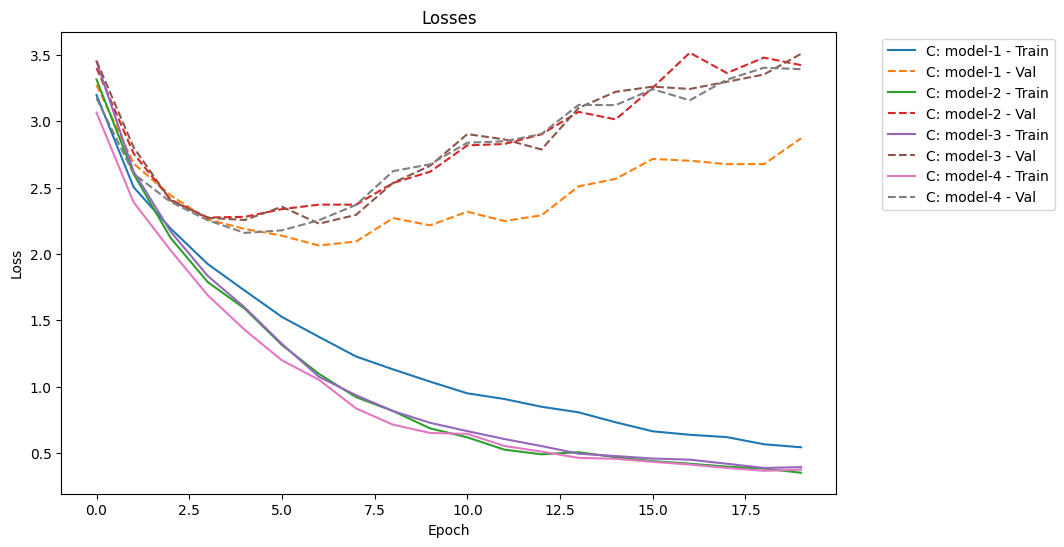

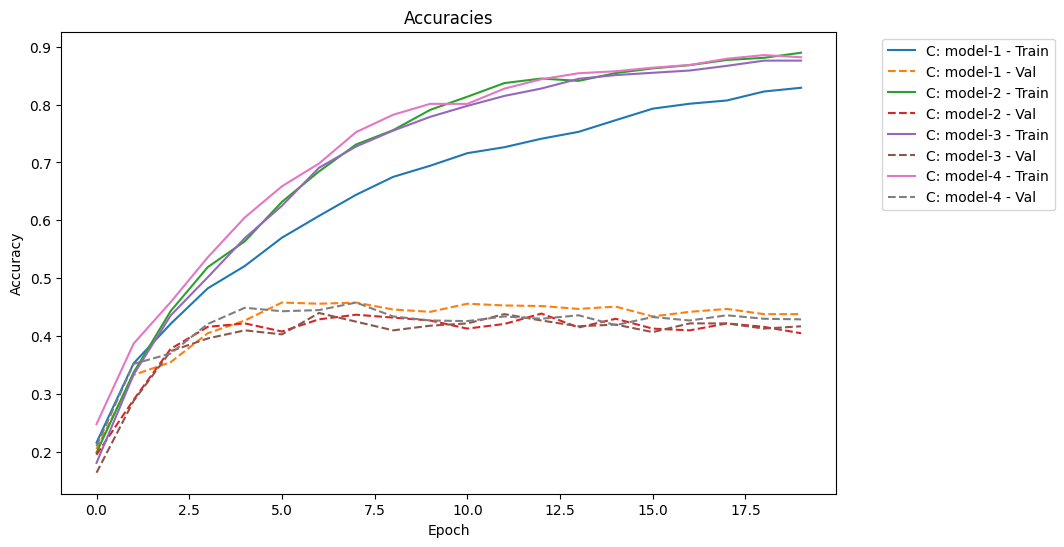

=== Final Evaluation with Best Weights ===
Channels: [64, 128, 256, 256], Pools: [False, True, True, True]
  Train Acc: 82.74%, Val Acc: 45.10%, Test Acc: 45.53%

Channels: [64, 128, 256, 256], Pools: [False, True, False, True]
  Train Acc: 88.80%, Val Acc: 43.40%, Test Acc: 42.88%

Channels: [64, 128, 128, 256], Pools: [False, True, False, True]
  Train Acc: 87.64%, Val Acc: 43.20%, Test Acc: 42.45%

Channels: [64, 64, 128, 128, 256], Pools: [False, True, False, True, False]
  Train Acc: 88.20%, Val Acc: 43.90%, Test Acc: 42.98%



In [16]:
plot_results(results)
evaluate_best_models(results, loader_train, loader_val, loader_test, DEVICE)

In [17]:
import pandas as pd

# Create DataFrame with selected columns
summary_df = pd.DataFrame([
    {
        'Model Name': r['name'],
        'Channels': r['channels'],
        'Pools': r['pools']
    }
    for r in results
])

# Display as a table
print(summary_df.to_string(index=False))


Model Name                Channels                             Pools
   model-1     [64, 128, 256, 256]         [False, True, True, True]
   model-2     [64, 128, 256, 256]        [False, True, False, True]
   model-3     [64, 128, 128, 256]        [False, True, False, True]
   model-4 [64, 64, 128, 128, 256] [False, True, False, True, False]
